# Path Planning for VEX Robots

Path planning is a fundamental aspect of robotics, enabling a robot to move from one point to another efficiently and safely. In the context of VEX robotics, path planning is especially important for autonomous routines, where the robot must navigate the field, avoid obstacles, and reach specific goals without human intervention.

A well-designed path planner allows a VEX robot to:
- **Follow smooth, precise trajectories** rather than simple straight lines or abrupt turns.
- **Account for the robot's physical constraints**, such as maximum speed, acceleration, and turning radius.
- **Navigate around field elements and obstacles** to optimize scoring or task completion.
- **Synchronize mechanisms** (like intakes or lifts) with movement for more complex autonomous actions.

Common path planning techniques for VEX robots include:
- **Waypoint following**: Defining a series of points for the robot to pass through.
- **Spline or Hermite curves**: Generating smooth curves between waypoints for natural motion.
- **Motion profiling**: Controlling speed and acceleration along the path for consistent, controllable movement.

In this notebook, we will explore how to generate and visualize smooth paths for a VEX robot using mathematical tools like Hermite splines and motion profiles. These concepts are directly applicable to real VEX robots, helping you design autonomous routines that are both reliable and competitive.

In [1]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt

## Define Robot and Field Parameters

For this project, we are modeling a VEX robot with a skid-steer drive and omni wheels. The robot can turn in place, so there is no minimum turning radius. However, to reduce drift and maintain control, we will limit the robot's speed based on the curvature of the path.

- **Field size:** 12 ft x 12 ft (144 in x 144 in)
- **All units:** Inches, inches/sec, etc.
- **Drive type:** Skid-steer with omni wheels (no minimum turning radius)
- **Constraint:** Velocity is limited by curvature to reduce drift, not by turning radius.

Define the (x, y) coordinates that the robot must pass through.

In [2]:
# Robot and Field Parameters (Imperial Units)
# This robot uses a skid-steer drive with omni wheels, so there is no minimum turning radius.
# The main concern is limiting velocity in turns to reduce drift.
max_velocity = 48  # inches per second
max_acceleration = 79  # inches per second squared

# VEX field is 12ft x 12ft (144in x 144in)
field_size = (144, 144)

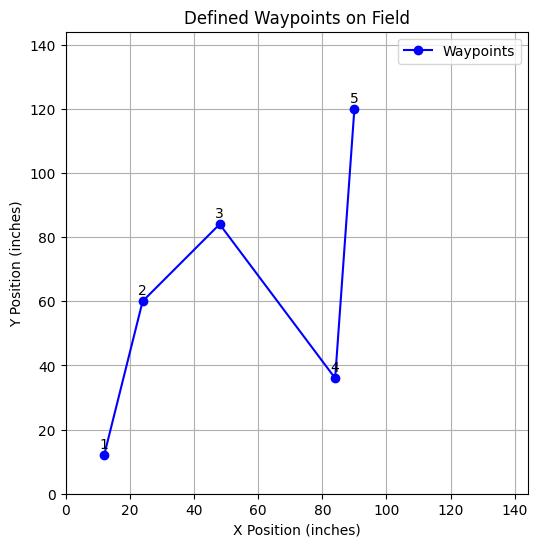

In [3]:
# Plot the waypoints on the field
import matplotlib.pyplot as plt

# Define waypoints as (x, y) coordinates in inches
waypoints = np.array([
    [12, 12],
    [24, 60],
    [48, 84],
    [84, 36],
    [90, 120]
])

plt.figure(figsize=(6,6))
plt.plot(waypoints[:,0], waypoints[:,1], 'o-', color='blue', label='Waypoints')
for i, (x, y) in enumerate(waypoints):
    plt.text(x, y+2, f'{i+1}', ha='center', fontsize=10, color='black')
plt.xlim(0, field_size[0])
plt.ylim(0, field_size[1])
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Defined Waypoints on Field')
plt.xlabel('X Position (inches)')
plt.ylabel('Y Position (inches)')
plt.grid(True)
plt.legend()
plt.show()

### Visualization: Waypoints on the Field

The chart below shows the defined waypoints on the VEX field. Each point represents a location the robot must pass through, labeled in order. This helps verify the intended path layout before generating the full path.

## Interpolate Path Between Waypoints (Linear Interpolation)

This approach matches the path generator coded in C++. The robot drives in straight lines from one waypoint to the next, just as in the C++ implementation.

### The Math
- For each pair of waypoints, calculate the difference in x and y.
- Use the equation of a line to find points between them:
    - $x = x_0 + t \cdot (x_1 - x_0)$
    - $y = y_0 + t \cdot (y_1 - y_0)$
  where $t$ goes from 0 to 1.
- This produces a set of points that form a straight path between each pair of waypoints, exactly as in the C++ path generator.

#### Visualization
The plot below shows the waypoints (orange dots) and the straight-line path (blue) the robot will follow.

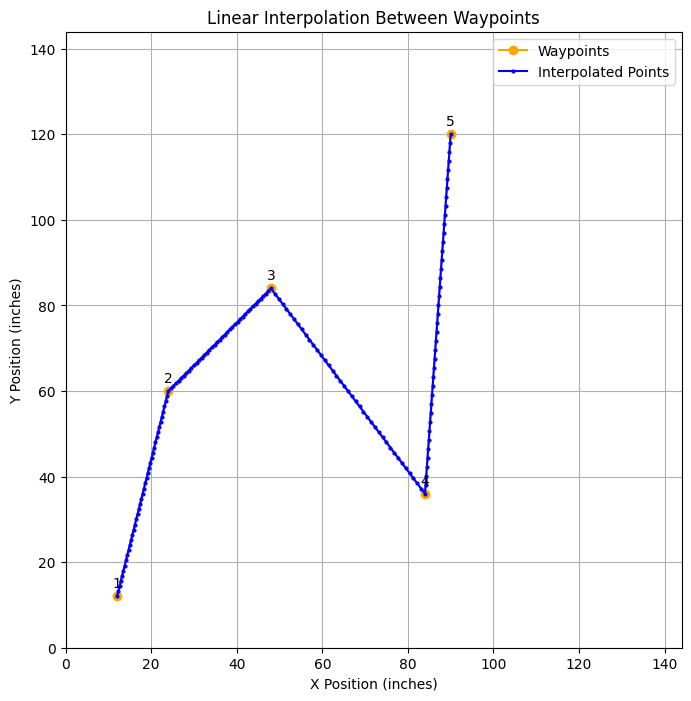

In [4]:
# Linear interpolation between waypoints
num_points_per_segment = 40
path_x = []
path_y = []
for i in range(len(waypoints) - 1):
    x0, y0 = waypoints[i]
    x1, y1 = waypoints[i+1]
    for t in np.linspace(0, 1, num_points_per_segment, endpoint=False):
        x = x0 + t * (x1 - x0)
        y = y0 + t * (y1 - y0)
        path_x.append(x)
        path_y.append(y)
# Add the last waypoint
path_x.append(waypoints[-1, 0])
path_y.append(waypoints[-1, 1])
path_x = np.array(path_x)
path_y = np.array(path_y)

# Plot the linear path and waypoints, highlighting interpolation
plt.figure(figsize=(8,8))
plt.plot(waypoints[:,0], waypoints[:,1], 'o-', color='orange', label='Waypoints')
plt.plot(path_x, path_y, 'b.-', label='Interpolated Points', markersize=4)
for i, (x, y) in enumerate(waypoints):
    plt.text(x, y+2, f'{i+1}', ha='center', fontsize=10, color='black')
plt.xlim(0, field_size[0])
plt.ylim(0, field_size[1])
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Linear Interpolation Between Waypoints')
plt.xlabel('X Position (inches)')
plt.ylabel('Y Position (inches)')
plt.grid(True)
plt.legend()
plt.show()

### Why Smooth Paths? (Cubic Hermite Splines)

While linear interpolation creates a path with sharp corners at each waypoint, our actual robot code uses smooth curves to generate a more natural, drivable path. This is done using cubic Hermite splines, which create a smooth transition between waypoints by blending position and heading information.

**Benefits of smooth paths:**
- Reduces sudden changes in direction (no sharp corners)
- Easier for the robot to follow at higher speeds
- Matches the physical constraints and control logic of our robot

The chart below shows a smooth path generated using cubic Hermite splines, similar to the approach in our C++ code.

### How to Compute a Cubic Hermite Spline

A cubic Hermite spline between two points uses the positions and tangents (directions) at each endpoint to create a smooth curve. The math for a point along the curve is:

- $P(t) = (2t^3 - 3t^2 + 1)P_0 + (t^3 - 2t^2 + t)M_0 + (-2t^3 + 3t^2)P_1 + (t^3 - t^2)M_1$

Where:
- $P_0$ and $P_1$ are the start and end points
- $M_0$ and $M_1$ are the tangents (direction vectors) at the start and end
- $t$ goes from 0 to 1

The code below computes the Hermite spline for each segment between waypoints, using the direction to the next/previous point as the tangent.

### Comparing Two Hermite Spline Approaches

There are two ways to generate Hermite splines between waypoints:

- **1. Segment-based Parameterization (First Graph):**
  - The parameter $t$ goes from 0 to 1 for each segment, but the spacing of points along the path does not account for the actual distance between waypoints.
  - This can cause the path to move unevenly, with points clustered in short segments and spread out in long segments.
  - The resulting path is smooth, but the robot may not move at a constant speed if it follows these points directly.

- **2. Distance-based Parameterization (Second Graph):**
  - The parameter $s$ is based on the cumulative distance along the path, so points are spaced evenly in terms of physical distance.
  - Tangents are normalized and scaled by the segment length, making the path more physically accurate for a robot to follow.
  - This approach ensures the robot moves smoothly and evenly along the path, which is important for real-world motion planning.

**Summary:**
- The first Hermite spline graph shows a mathematically smooth path, but the spacing of points may not match the robot's actual movement.
- The second Hermite spline graph produces a path that is both smooth and physically meaningful, with even spacing and correct tangent scaling, making it better for real robot path following.

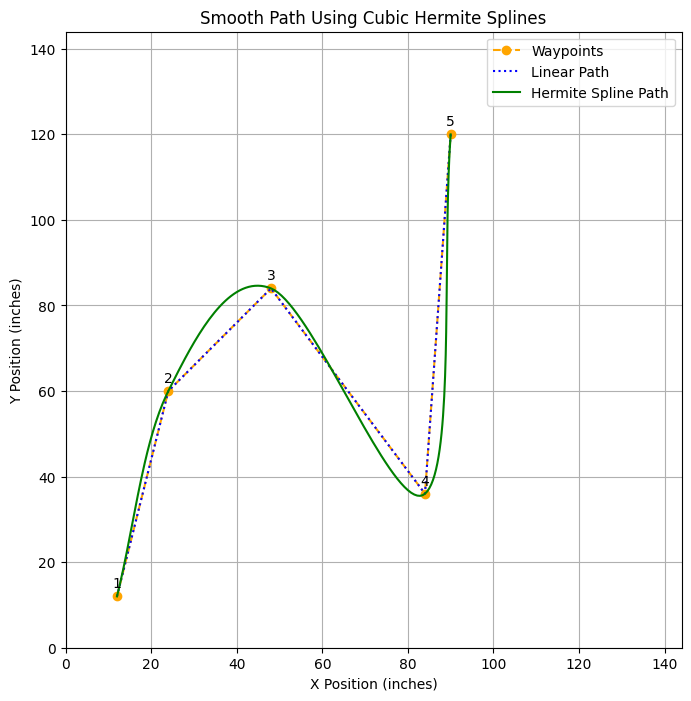

In [5]:
# Compute and plot a smooth cubic Hermite spline path (no libraries)
def compute_hermite_spline(P0, P1, M0, M1, num_points=40):
    t = np.linspace(0, 1, num_points)
    h00 = 2*t**3 - 3*t**2 + 1
    h10 = t**3 - 2*t**2 + t
    h01 = -2*t**3 + 3*t**2
    h11 = t**3 - t**2
    x = h00*P0[0] + h10*M0[0] + h01*P1[0] + h11*M1[0]
    y = h00*P0[1] + h10*M0[1] + h01*P1[1] + h11*M1[1]
    return x, y

# Estimate tangents at each waypoint (direction to next/prev point)
hermite_tangents = []
for i in range(len(waypoints)):
    if i == 0:
        tangent = waypoints[1] - waypoints[0]
    elif i == len(waypoints) - 1:
        tangent = waypoints[-1] - waypoints[-2]
    else:
        tangent = (waypoints[i+1] - waypoints[i-1]) / 2
    hermite_tangents.append(tangent)
hermite_tangents = np.array(hermite_tangents)

# Build the full smooth path
hermite_x = []
hermite_y = []
for i in range(len(waypoints)-1):
    P0 = waypoints[i]
    P1 = waypoints[i+1]
    M0 = hermite_tangents[i]
    M1 = hermite_tangents[i+1]
    x_seg, y_seg = compute_hermite_spline(P0, P1, M0, M1, num_points=40)
    if i > 0:
        # Avoid duplicating points at segment joins
        x_seg = x_seg[1:]
        y_seg = y_seg[1:]
    hermite_x.extend(x_seg)
    hermite_y.extend(y_seg)
hermite_x = np.array(hermite_x)
hermite_y = np.array(hermite_y)

# Plot
plt.figure(figsize=(8,8))
plt.plot(waypoints[:,0], waypoints[:,1], 'o--', label='Waypoints', color='orange')
plt.plot(path_x, path_y, ':', label='Linear Path', color='blue')
plt.plot(hermite_x, hermite_y, '-', label='Hermite Spline Path', color='green')
for i, (x, y) in enumerate(waypoints):
    plt.text(x, y+2, f'{i+1}', ha='center', fontsize=10, color='black')
plt.xlim(0, field_size[0])
plt.ylim(0, field_size[1])
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Smooth Path Using Cubic Hermite Splines')
plt.xlabel('X Position (inches)')
plt.ylabel('Y Position (inches)')
plt.grid(True)
plt.legend()
plt.show()

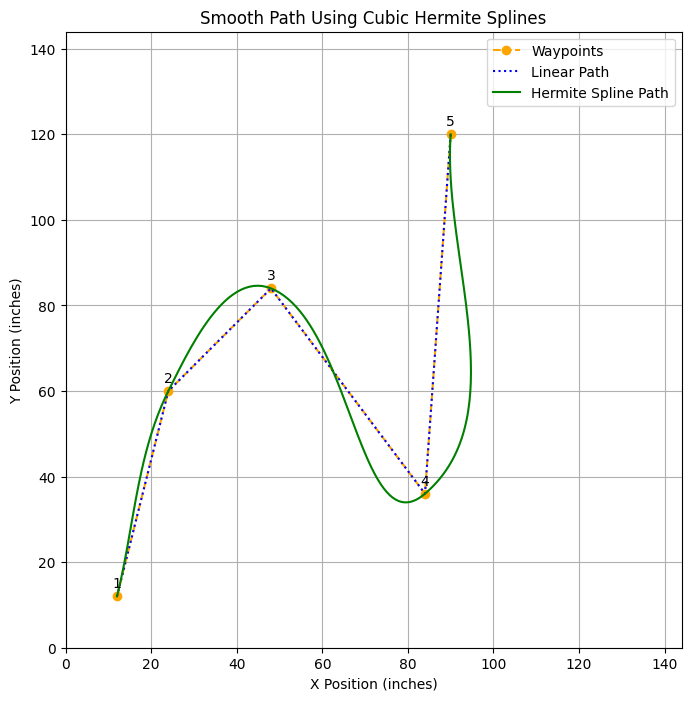

In [6]:
# Compute and plot a smooth Hermite spline path (parameterized by distance, fixed tangent scaling)
# Parameterize waypoints by cumulative distance
waypoint_dist = np.zeros(len(waypoints))
for i in range(1, len(waypoints)):
    waypoint_dist[i] = waypoint_dist[i-1] + np.linalg.norm(waypoints[i] - waypoints[i-1])

# Estimate tangents at each waypoint (unit direction vectors)
hermite_tangents = []
for i in range(len(waypoints)):
    if i == 0:
        tangent = waypoints[1] - waypoints[0]
    elif i == len(waypoints) - 1:
        tangent = waypoints[-1] - waypoints[-2]
    else:
        tangent = (waypoints[i+1] - waypoints[i-1]) / 2
    norm = np.linalg.norm(tangent)
    if norm > 0:
        tangent = tangent / norm
    hermite_tangents.append(tangent)
hermite_tangents = np.array(hermite_tangents)

# Sample the smooth path along the cumulative distance
num_samples = 200
s_dist = np.linspace(waypoint_dist[0], waypoint_dist[-1], num_samples)
hermite_x = []
hermite_y = []

# For each segment, compute Hermite spline points for s in that segment
for i in range(len(waypoints)-1):
    s0 = waypoint_dist[i]
    s1 = waypoint_dist[i+1]
    mask = (s_dist >= s0) & (s_dist <= s1)
    t = (s_dist[mask] - s0) / (s1 - s0) if s1 > s0 else np.zeros_like(s_dist[mask])
    P0 = waypoints[i]
    P1 = waypoints[i+1]
    M0 = hermite_tangents[i]
    M1 = hermite_tangents[i+1]
    h00 = 2*t**3 - 3*t**2 + 1
    h10 = t**3 - 2*t**2 + t
    h01 = -2*t**3 + 3*t**2
    h11 = t**3 - t**2
    # Only scale the tangent by segment length inside the Hermite formula
    x = h00*P0[0] + h10*M0[0]*(s1-s0) + h01*P1[0] + h11*M1[0]*(s1-s0)
    y = h00*P0[1] + h10*M0[1]*(s1-s0) + h01*P1[1] + h11*M1[1]*(s1-s0)
    hermite_x.extend(x)
    hermite_y.extend(y)
hermite_x = np.array(hermite_x)
hermite_y = np.array(hermite_y)

# Plot
plt.figure(figsize=(8,8))
plt.plot(waypoints[:,0], waypoints[:,1], 'o--', label='Waypoints', color='orange')
plt.plot(path_x, path_y, ':', label='Linear Path', color='blue')
plt.plot(hermite_x, hermite_y, '-', label='Hermite Spline Path', color='green')
for i, (x, y) in enumerate(waypoints):
    plt.text(x, y+2, f'{i+1}', ha='center', fontsize=10, color='black')
plt.xlim(0, field_size[0])
plt.ylim(0, field_size[1])
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Smooth Path Using Cubic Hermite Splines')
plt.xlabel('X Position (inches)')
plt.ylabel('Y Position (inches)')
plt.grid(True)
plt.legend()
plt.show()

#### Comparing Linear and Smooth Paths

The green curve above shows the smooth path generated using cubic Hermite splines, which closely matches the path your robot will actually follow. The blue dotted line shows the sharp, linear path for comparison. In practice, the robot follows the smooth path to avoid abrupt turns and maintain better control, as implemented in the C++ code.

### Analyzing the Smooth Path

Now that we have generated a smooth path using Hermite splines, we can analyze its properties to ensure it is suitable for the robot to follow. The next steps—curvature calculation, velocity profiling, and simulation—will use the smooth path (`hermite_x`, `hermite_y`) rather than the linear path. This ensures our analysis matches the actual path the robot will drive.

### What Are Splines? Why Use Hermite Splines for Path Planning?

**What is a spline?**
A spline is a smooth curve that passes through or near a set of points. In robotics and computer graphics, splines are used to create paths or shapes that are smooth and continuous, rather than made up of straight lines with sharp corners.

**Types of splines:**
- **Bezier splines:** Defined by control points, commonly used for graphics and animation. They are easy to use but do not directly control the tangent (direction) at each point.
- **B-splines and NURBS:** More advanced, allow for complex shapes and local control, often used in CAD and modeling.
- **Hermite splines:** Defined by endpoints and the tangent (direction and speed) at each endpoint. This allows precise control over both the position and the direction of the curve at each waypoint.

**Why Hermite splines for robot path planning?**
- Hermite splines let you specify not just where the robot should go (the waypoints), but also the direction it should be facing as it passes each point.
- This is important for robots, because the heading (direction) affects how the robot moves and turns, and allows for smoother, more controllable paths.
- Hermite splines naturally produce curves with continuous position and direction, which means the robot can follow the path without sudden changes in steering or speed.

**Summary:**
Hermite splines are a practical choice for robot path planning because they provide smooth, drivable curves that respect both the position and heading constraints at each waypoint, making them ideal for autonomous navigation.

## Calculating Path Curvature

Curvature describes how sharply the path turns at each point. High curvature means a tight turn, while low curvature means a straight path. Calculating curvature on the smooth Hermite spline path is important for determining where the robot needs to slow down to maintain control and avoid skidding. This is a key step in engineering a path that is both fast and safe for the robot to follow, and is the basis for generating a physically realistic velocity profile.

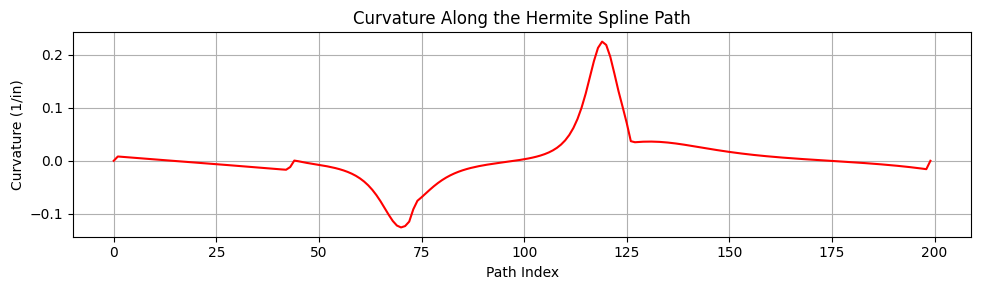

In [7]:
# Use the smooth Hermite spline path for analysis
path_points = np.stack([hermite_x, hermite_y], axis=1)
deltas = np.diff(path_points, axis=0)
segment_lengths = np.linalg.norm(deltas, axis=1)
path_length = np.sum(segment_lengths)

# For Hermite spline, curvature is calculated at each point (with sign)
curvature = np.zeros_like(hermite_x)
for i in range(1, len(hermite_x)-1):
    v1 = np.array([hermite_x[i] - hermite_x[i-1], hermite_y[i] - hermite_y[i-1]])
    v2 = np.array([hermite_x[i+1] - hermite_x[i], hermite_y[i+1] - hermite_y[i]])
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 > 0 and norm2 > 0:
        cross = v1[0]*v2[1] - v1[1]*v2[0]
        sign = np.sign(cross)
        angle = np.arccos(np.clip(np.dot(v1, v2) / (norm1 * norm2), -1.0, 1.0))
        curvature[i] = sign * angle / (0.5 * (norm1 + norm2))

# Visualize curvature along the path
plt.figure(figsize=(10, 3))
plt.plot(curvature, color='red')
plt.xlabel('Path Index')
plt.ylabel('Curvature (1/in)')
plt.title('Curvature Along the Hermite Spline Path')
plt.grid(True)
plt.tight_layout()
plt.show()

## Generating a Velocity Profile Based on Curvature

To ensure the robot can safely follow the path, we calculate a velocity profile that slows the robot down for sharp turns and allows higher speeds on straight sections. This is done by limiting the maximum velocity at each point based on the curvature.

### Forward and Backward Passes for Motion Profiling

A real robot cannot instantly accelerate or decelerate. To generate a physically realistic velocity profile, we use two passes:
- **Forward pass:** Starting from zero velocity, we limit the speed at each point so the robot never accelerates faster than its maximum allowed acceleration.
- **Backward pass:** Starting from the end (also at zero velocity), we limit the speed at each point so the robot can always slow down in time for upcoming turns.

This two-pass approach, combined with S-curve motion profiling, ensures smooth acceleration and deceleration, and matches the way motion profiling is implemented in the C++ code.

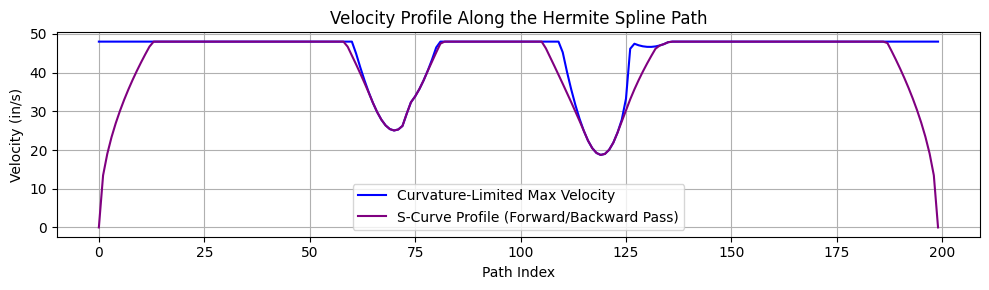

In [8]:
# Calculate max velocity at each point based on curvature
with np.errstate(divide='ignore', invalid='ignore'):
    v_curve = np.sqrt(np.abs(max_acceleration / (np.abs(curvature) + 1e-6)))
    v_profile = np.minimum(v_curve, max_velocity)
    v_profile = np.nan_to_num(v_profile, nan=max_velocity, posinf=max_velocity, neginf=0)

# Forward pass (acceleration limit, start at zero)
forward = np.zeros_like(v_profile)
forward[0] = 0.0
for i in range(1, len(v_profile)):
    ds = np.linalg.norm([hermite_x[i] - hermite_x[i-1], hermite_y[i] - hermite_y[i-1]])
    forward[i] = min(v_profile[i], np.sqrt(forward[i-1]**2 + 2 * max_acceleration * ds))

# Backward pass (deceleration limit, end at zero)
backward = np.zeros_like(v_profile)
backward[-1] = 0.0
for i in range(len(v_profile)-2, -1, -1):
    ds = np.linalg.norm([hermite_x[i+1] - hermite_x[i], hermite_y[i+1] - hermite_y[i]])
    backward[i] = min(forward[i], np.sqrt(backward[i+1]**2 + 2 * max_acceleration * ds))

# The final velocity profile is the result of both passes
s_curve_profile = backward

plt.figure(figsize=(10, 3))
plt.plot(v_profile, color='blue', label='Curvature-Limited Max Velocity')
plt.plot(s_curve_profile, color='purple', label='S-Curve Profile (Forward/Backward Pass)')
plt.xlabel('Path Index')
plt.ylabel('Velocity (in/s)')
plt.title('Velocity Profile Along the Hermite Spline Path')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Calculating Left and Right Wheel Velocities from Curvature

For a differential drive (skid-steer) robot, the left and right wheels must spin at different speeds to follow a curved path. The curvature at each point along the path tells us how much faster one side must go compared to the other.

- When the curvature is zero (straight line), both wheels move at the same speed.
- When the curvature is positive or negative (turning), the wheels move at different speeds to create the desired turning radius.

The formulas below show how to compute the left and right wheel velocities from the path velocity and curvature, given the robot's track width (distance between left and right wheels):

- $v_{left} = v_{center} \times (1 - \kappa \cdot w/2)$
- $v_{right} = v_{center} \times (1 + \kappa \cdot w/2)$

where:
- $v_{center}$ is the velocity along the path (from the S-curve profile)
- $\kappa$ is the curvature at that point
- $w$ is the track width of the robot

This ensures the robot follows the planned path accurately by commanding the correct wheel speeds at every point.

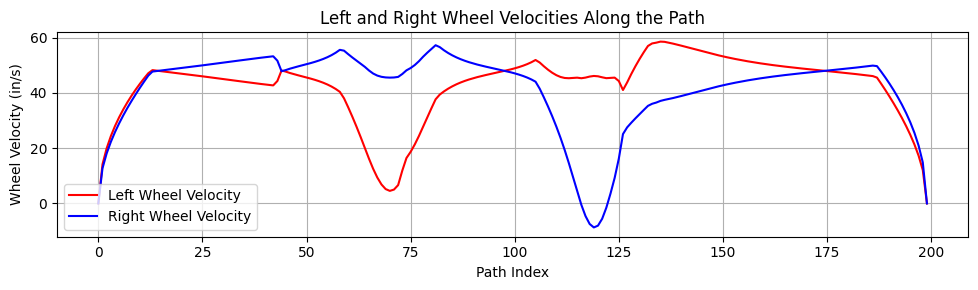

In [9]:
# Example: Compute and plot left/right wheel velocities for a differential drive robot
track_width = 13.0  # inches (example value, set to your robot's actual track width)

# Compute left and right wheel velocities (sign flip for correct convention)
v_left = s_curve_profile * (1 + curvature * track_width / 2)
v_right = s_curve_profile * (1 - curvature * track_width / 2)

plt.figure(figsize=(10, 3))
plt.plot(v_left, label='Left Wheel Velocity', color='red')
plt.plot(v_right, label='Right Wheel Velocity', color='blue')
plt.xlabel('Path Index')
plt.ylabel('Wheel Velocity (in/s)')
plt.title('Left and Right Wheel Velocities Along the Path')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Visualizing Robot Heading Along the Path

The robot's heading (direction it is facing) changes as it follows the path. Visualizing heading over time helps engineers understand how the robot will turn and orient itself, which is important for tuning control algorithms and ensuring smooth motion.

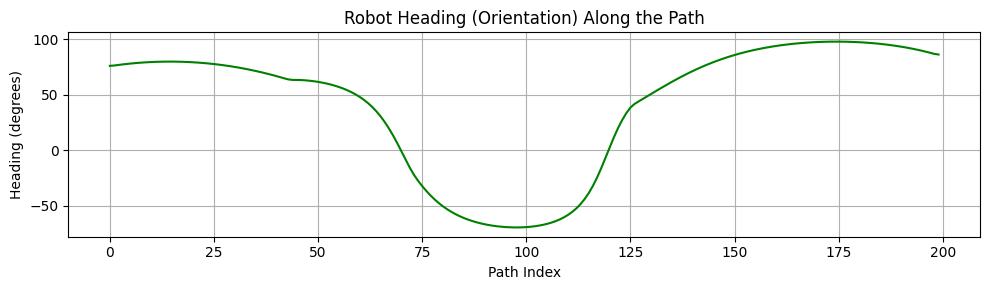

In [10]:
# Calculate and plot robot heading (orientation) along the path
headings = np.unwrap(np.arctan2(np.gradient(hermite_y), np.gradient(hermite_x)))
plt.figure(figsize=(10, 3))
plt.plot(np.degrees(headings), color='green')
plt.xlabel('Path Index')
plt.ylabel('Heading (degrees)')
plt.title('Robot Heading (Orientation) Along the Path')
plt.grid(True)
plt.tight_layout()
plt.show()

## Visualizing Robot Speed on the Path (Color Gradient)

Instead of plotting speed as a separate graph, we can visualize the robot's speed directly on the Hermite spline path by coloring each segment according to the S-curve velocity profile. This makes it easy to see where the robot speeds up and slows down along the actual path, providing an intuitive engineering view of speed constraints in context.

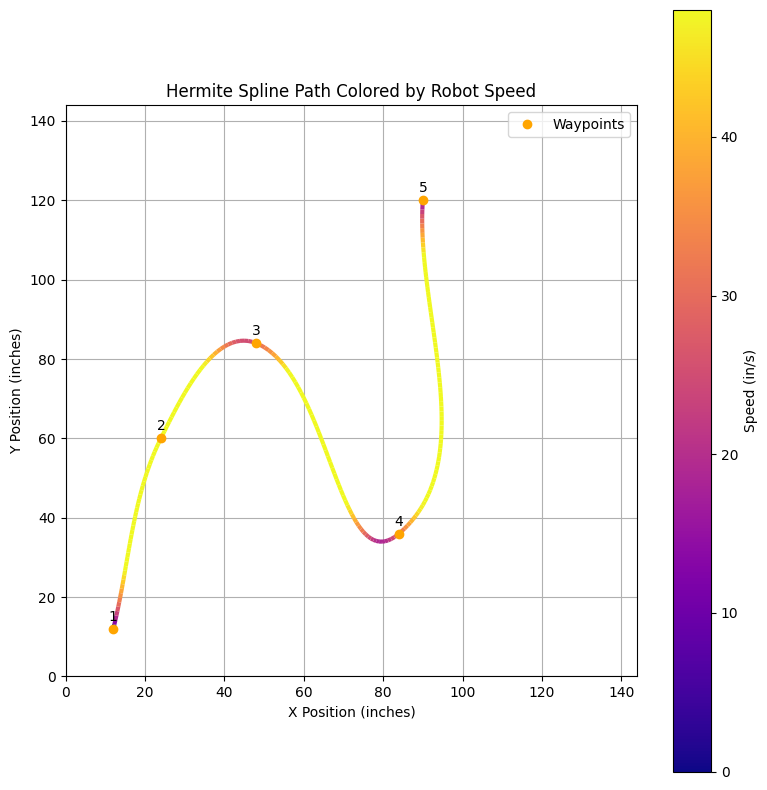

In [11]:
# Plot Hermite spline path with color gradient for speed
import matplotlib.collections as mcoll

# Prepare segments for LineCollection
points = np.array([hermite_x, hermite_y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
speeds = s_curve_profile[:-1]  # Color by speed at each segment

fig, ax = plt.subplots(figsize=(8, 8))
lc = mcoll.LineCollection(segments, array=speeds, cmap='plasma', linewidth=3)
line = ax.add_collection(lc)
plt.colorbar(line, ax=ax, label='Speed (in/s)')

# Plot waypoints
ax.plot(waypoints[:,0], waypoints[:,1], 'o', color='orange', label='Waypoints')
for i, (x, y) in enumerate(waypoints):
    ax.text(x, y+2, f'{i+1}', ha='center', fontsize=10, color='black')

ax.set_xlim(0, field_size[0])
ax.set_ylim(0, field_size[1])
ax.set_aspect('equal', adjustable='box')
ax.set_title('Hermite Spline Path Colored by Robot Speed')
ax.set_xlabel('X Position (inches)')
ax.set_ylabel('Y Position (inches)')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

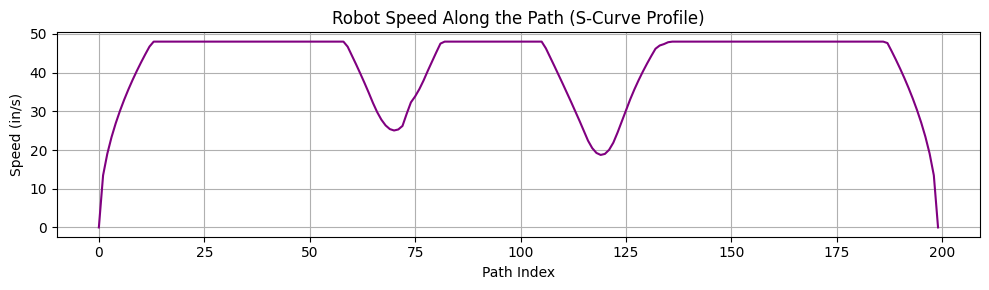

In [12]:
# Plot robot speed (S-curve profile) at each point along the path
plt.figure(figsize=(10, 3))
plt.plot(s_curve_profile, color='purple')
plt.xlabel('Path Index')
plt.ylabel('Speed (in/s)')
plt.title('Robot Speed Along the Path (S-Curve Profile)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Summary and Engineering Reflection


This notebook demonstrated a complete workflow for planning a robot path using waypoints, generating both linear and smooth (Hermite spline) paths, and analyzing the path for curvature and velocity constraints. By visualizing curvature, velocity, and robot heading, we ensured the path is both efficient and safe for the robot to follow. These engineering tools and visualizations are essential for designing reliable autonomous routines in robotics competitions.

**Online Resources:**
- [Wikipedia: Spline (mathematics)](https://en.wikipedia.org/wiki/Spline_(mathematics))
- [Paul Bourke: Bezier Curves](http://paulbourke.net/geometry/bezier/)

These resources provide more detail on the theory and application of splines in robotics, computer graphics, and engineering.